In [1]:
import statistics
from collections import defaultdict
from tqdm.notebook import tqdm

import pyro
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(7)
pyro.set_rng_seed(0)
np.random.seed(19680801)

from pyro.infer import SVI, Trace_ELBO, Importance, EmpiricalMarginal
import torch.distributions.constraints as constraints
from pyro.optim import Adam
import time
# Constants
MAX_ABUNDANCE = 100

In [2]:
print(time.asctime())

Thu Dec 17 22:29:42 2020


In [3]:
# load data
data_path = "../Tests/Data/mapk3000.csv"

data = pd.read_csv(data_path)
num_samples = data.shape[0]

single_interaction_data = data[["a(p(Mek))","a(p(Erk))"]]
single_interaction_data.to_csv("../Tests/Data/single_interaction_data.csv")

parent = single_interaction_data["a(p(Mek))"].to_numpy()
target = single_interaction_data["a(p(Erk))"].to_numpy()

In [4]:

# # Log transformation
def transform_target_to_log(target):
    return np.log(target / (MAX_ABUNDANCE - target))



target_transformed_to_log = transform_target_to_log(target)


Features = np.vstack([parent, np.ones(len(parent))]).T


In [5]:
# Linear Regression - get slope and intercept
w, b = np.linalg.lstsq(Features, target_transformed_to_log, rcond=None)[0]


In [6]:
w, b

(0.012194037707409228, 0.946018143974357)

In [7]:
np.exp(-1*(0.012194037707409228*60 + 0.946018143974357))

0.1868105258728995

In [8]:
denominator = 1+np.exp(-1*(0.012194037707409228*60 + 0.946018143974357 -2))
denominator

2.38035345554559

In [9]:
MAX_ABUNDANCE / denominator

42.0105677024673

In [10]:


# sigmoid function
def sigmoid(x, w, b):
    return MAX_ABUNDANCE / (1 + np.exp(-1*(w*x + b)))

predicted_target = sigmoid(parent, w, b)
print(predicted_target[:6])

print(target[:6])

[83.60167356 86.53634856 83.43381645 84.42050169 85.66090416 82.22011114]
[82 91 79 87 86 81]


In [11]:
def test_sigmoid(c):
    return MAX_ABUNDANCE / (1 + np.exp(-1*(c)))

In [12]:
print(test_sigmoid(80))
print(test_sigmoid(82))
print(test_sigmoid(84))

100.0
100.0
100.0


In [13]:

# Report mean squared error

mse = np.square(np.subtract(target, predicted_target)).mean()

print("Mean squared error on train:", mse)

Mean squared error on train: 13.276608518288601


### Regression line in log space

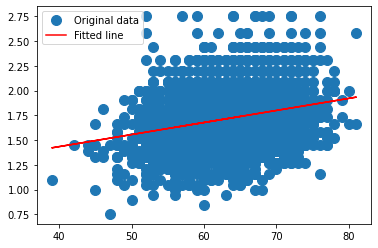

In [14]:
_ = plt.plot(parent, target_transformed_to_log, 'o', label='Original data', markersize=10)
_ = plt.plot(parent, w*parent + b, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

### Regression line in actual space 

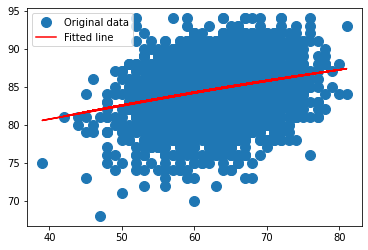

In [15]:
_ = plt.plot(parent, target, 'o', label='Original data', markersize=10)
_ = plt.plot(parent, predicted_target, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

### get residual and parent statistics

In [16]:
residual_std = np.abs(np.subtract(target, predicted_target)).std()
print(residual_std)

parent_mean = parent.mean()
parent_std = parent.std()

2.2139925169162327


In [17]:
residual_ratio = (target / predicted_target).mean()

### Define Pyro model

In [18]:

# sigmoid with noise
def sigmoid_with_residual_noise(x, w, b, noise):
    return MAX_ABUNDANCE / (1 + np.exp(-1*(w*x + b + noise)))

# pyro model
def model(n_erk):
    noise = pyro.sample("n_Erk", n_erk)
    mek = pyro.sample("Mek", pyro.distributions.Normal(parent_mean, parent_std))
    
#     erk_mean = sigmoid_with_residual_noise(mek.detach().numpy(), w, b, noise.detach().numpy())
    erk_mean = sigmoid(mek.detach().numpy(), w, b)+noise
    erk = pyro.sample("Erk", pyro.distributions.Normal(torch.tensor(erk_mean), torch.tensor(1.0)))
    return mek,erk

In [19]:
n_erk = pyro.distributions.Normal(torch.tensor(0.0), torch.tensor(residual_std))
samples = torch.tensor([model(n_erk) for _ in range(3000)])

<ipython-input-18-60a34a83e451>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  erk = pyro.sample("Erk", pyro.distributions.Normal(torch.tensor(erk_mean), torch.tensor(1.0)))


In [20]:
samples[:20]

tensor([[61.4891, 85.7318],
        [56.9296, 83.6164],
        [68.0103, 85.6858],
        [59.7416, 83.5066],
        [69.5237, 82.7713],
        [59.9163, 84.8907],
        [54.4825, 81.7419],
        [68.5970, 89.6000],
        [70.4643, 85.0132],
        [63.0600, 82.2781],
        [55.6156, 84.8776],
        [50.3923, 84.1032],
        [60.2942, 82.3006],
        [62.9474, 82.9857],
        [57.9096, 82.8131],
        [64.2721, 84.1288],
        [62.9762, 89.3530],
        [69.5159, 86.7979],
        [57.8115, 82.7848],
        [70.8067, 84.5031]], dtype=torch.float64)

In [21]:
print(sigmoid_with_residual_noise(60, w, b, 0.5))
print(sigmoid_with_residual_noise(60, w, b, -0.5))
print(sigmoid_with_residual_noise(60, w, b, -1))
print(sigmoid_with_residual_noise(60, w, b, -2))

89.82253937405616
76.45268778841701
66.32163244842576
42.0105677024673


In [22]:
w, b

(0.012194037707409228, 0.946018143974357)

### Generated samples Vs. Original Data

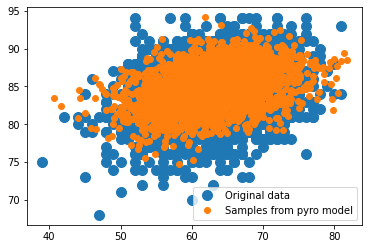

In [23]:
_ = plt.plot(parent, target, 'o', label='Original data', markersize=10)
_ = plt.plot(samples[:,0], samples[:,1], 'o', label='Samples from pyro model')
_ = plt.legend()
plt.show()

## Counterfactual Inference

In [24]:

def infer_using_svi(conditioned_model, n_erk):

    def guide(n_erk):
        mu_constraints = constraints.interval(0., 5.)
        sigma_constraints = constraints.interval(.1, 7.)
        mu_guide = pyro.param("mu_n_Erk", torch.tensor(0.0), constraint=mu_constraints)
        sigma_guide = pyro.param("sigma_n_Erk", torch.tensor(residual_std),
                                     constraint=sigma_constraints)
        pyro.sample("n_Erk", pyro.distributions.Normal(mu_guide, sigma_guide))

    pyro.clear_param_store()

    svi = SVI(
        model=conditioned_model,
        guide=guide,
        optim=Adam({"lr": 0.0005, "betas": (0.95, 0.999)}),
        loss=Trace_ELBO(retain_graph=True)
    )
    losses = []
    num_steps = 1000
    samples = defaultdict(list)
    for t in tqdm(range(num_steps)):
        loss = svi.step(n_erk)
        #print(t, loss)
        losses.append(loss)
        mu = 'mu_n_Erk'
        sigma = 'sigma_n_Erk'
        samples[mu].append(pyro.param(mu).item())
        samples[sigma].append(pyro.param(sigma).item())
    means = {k: statistics.mean(v) for k, v in samples.items()}

    updated_noise = {}
    updated_noise = pyro.distributions.Normal(means["mu_n_Erk"], means["sigma_n_Erk"])

    return updated_noise, losses

In [25]:
def counterfactual_inference(intervened_mek):
    n_erk = pyro.distributions.Normal(0.0, torch.tensor(residual_std))

    # Generate a sample
    observed_mek, observed_erk = model(n_erk)

    print("Observed Mek:", observed_mek, "Observed Erk:", observed_erk)
    print("What would happen to Erk if Mek was", intervened_mek, "?")
    conditioned_model = pyro.condition(model, data={"Mek": observed_mek, "Erk": observed_erk})
    updated_n_erk = infer_using_svi(conditioned_model, n_erk)

    intervention_model = pyro.do(model, data={"Mek":torch.tensor(intervened_mek)})
    return intervention_model, updated_n_erk[0]

In [26]:
intervened_model_1, noise_1 = counterfactual_inference(60.)
intervened_model_2, noise_2 = counterfactual_inference(80.)

counterfactual_erk_1 = torch.tensor([intervened_model_1(noise_1)[1] for _ in range(1000)])
counterfactual_erk_2 = torch.tensor([intervened_model_2(noise_2)[1] for _ in range(1000)])

Observed Mek: tensor(61.7590) Observed Erk: tensor(88.3985, dtype=torch.float64)
What would happen to Erk if Mek was 60.0 ?


<ipython-input-18-60a34a83e451>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  erk = pyro.sample("Erk", pyro.distributions.Normal(torch.tensor(erk_mean), torch.tensor(1.0)))



Observed Mek: tensor(66.5967) Observed Erk: tensor(85.8043, dtype=torch.float64)
What would happen to Erk if Mek was 80.0 ?


In [27]:
noise_1, noise_2

(Normal(loc: 5.877471754111438e-38, scale: 2.2079570293426514),
 Normal(loc: 5.877471754111438e-38, scale: 2.2226152420043945))

In [28]:
print(counterfactual_erk_1[:10])
print(counterfactual_erk_2[:10])

tensor([81.1827, 87.5503, 86.4231, 88.0284, 78.1632, 85.8330, 88.8836, 85.5052,
        85.2543, 84.3440])
tensor([87.9966, 85.6225, 91.6403, 84.3464, 88.6346, 84.9627, 87.4882, 84.0983,
        87.6374, 85.9124])


In [29]:
print("Counterfactual Erk when Mek = 60:: Mean", counterfactual_erk_1.mean(), counterfactual_erk_1.std())
print("Counterfactual Erk when Mek = 80:: Mean", counterfactual_erk_2.mean(), counterfactual_erk_2.std())

Counterfactual Erk when Mek = 60:: Mean tensor(84.2577) tensor(2.5393)
Counterfactual Erk when Mek = 80:: Mean tensor(87.3197) tensor(2.4001)
